In [128]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score



# Helper Functions

These functions train a model on your data and use cross validation to determine the average negative mean squared error. You do not have to edit these! However, it might make sense to add new helper functions here.

In [129]:
def scoreLinear(X, y):
    """Trains a linear regression model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    regr = linear_model.LinearRegression()
    scores = cross_val_score(regr, X, y, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [130]:
def scoreBoosting(X, y):
    """Trains a gradient boosting model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='squared_error')
    # clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='ls') # older versions

    scores = cross_val_score(clf, X, np.ravel(y), cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [131]:
def dataframeToXy(df, predict_column, feature_columns):
    """Convert the dataframe to a format usable for the ML algorithms"""
    X = df[feature_columns].values.reshape(-1, df[feature_columns].shape[1]) # all features
    y = df[[predict_column]].values.reshape(-1, 1) # values to predict
    return X, y

In [132]:
def runScoring(df, predict_column, feature_columns):
    """This runs both algorithms to determine the scores for all given features in the dataset.
    
    Parameters: 
    df (dataframe): dataframe with Score and features
    predict_column: name of the value to predict, e.g. 'Score'
    feature_columns: list of all column names that are to be used as features
  
    Returns: 
    linear: negative mean squared error of linear regression
    boost: negative mean squared error of boosting algorithm
    """
    X, y = dataframeToXy(df, predict_column, feature_columns)
    boost = scoreBoosting(X, y)
    linear = scoreLinear(X, y)
    return linear, boost

In [133]:
def runScoringSimple(df, predict_column):
    """Alternative to function above, this takes all the columns in the 
    dataframe as features except the single column which is used for the score.
    """
    all_feature_columns = list(df.columns)
    all_feature_columns.remove(predict_column)
    return runScoring(df, predict_column, all_feature_columns)

In [134]:
def createBaselineRandom(df, predict_column):
    """creates random features and returns the average score after 20 rounds"""
    np.random.seed(0)
    baseline = df[['Score']].copy()
    averageLinearScore = 0
    averageBoostingScore = 0
    rounds = 20
    for i in range(rounds):
        baseline['feature1'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature2'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature3'] = np.random.randint(0, 100, df.shape[0])
        lin, boost = runScoring(baseline, predict_column, ['feature1', 'feature2', 'feature3'])
        averageLinearScore += lin / rounds
        averageBoostingScore += boost / rounds
    print(f'linear   : {averageLinearScore}')
    print(f'boosting : {averageBoostingScore}')

# Load Data

Recommended: Make sure you have a column named 'Score', preferably as the first column, while the name of the municipality is the index. It is fine to use your previous notebook from assignment 1 to export the data to a .csv or excel and simply import the file here, you do not have to show the code for that. Your initial dataframe should look somewhat like the one below, with more features of course.

In [135]:
def cleanup_municipal_names_df(df):
    df['Gemeinde'] = df['Gemeinde'].str.replace('St', 'Saint')
    df['Gemeinde'] = df['Gemeinde'].str.replace('Sainte', 'Saint')
    df['Gemeinde'] = df['Gemeinde'].str.replace('’', '\'')
    df['Gemeinde'] = df['Gemeinde'].str.replace(' (VD)', '')
    df['Gemeinde'] = df['Gemeinde'].str.replace(' (Payerne)', '')
    df['Gemeinde'] = df['Gemeinde'].str.replace('–', '-')
    return df

df_base = pd.read_csv('./raw/2_ranking.csv').rename(columns={
    'community_name': 'Gemeinde',
    'score': 'Score',
})[['Gemeinde', 'Score']]

df_base = cleanup_municipal_names_df(df_base)

df_base = df_base.set_index('Gemeinde')

display(df_base)

,Score
Gemeinde,
Mauraz,81.521098
Villars-Epeney,79.553418
Démoret,72.996232
Chavannes-près-Renens,64.626157
Bettens,59.089791
...,...
Saint-Croix,9.478984
Le Chenit,9.239010
Corseaux,8.788699


These are the features that were used to create the original ranking in Assignment 1:  

The scores above were taken from the ranking 2 of assignment 1. The following features were used to create the ranking: (this is an extract from the readme file of assignment 1)

>
> ## Rangliste 2
> 
> Quelle OpenData Vaud, siehe [`2_ranking.ipynb`](/assignment1/2_ranking.ipynb)
> 
> Die Rangliste wurde aufgrund der Daten von OpenData Vaud erstellt. Die Rangliste besitzt folgende Kriterien:
> 
> 1. Anteil Personen in arbeitstätigem Alter\
>    Wie viel Prozent der arbeitstätigen Personen sind zwischen 15 und 64 Jahre alt? Die Prozentzahl wird als Punkte vergeben.
> 2. Verteilung der Altersklassen\
>    Gibt es bei der Bevölkerung grosse Abweichungen bei den Altersklassen? Eine Altersklasse enthält jeweils 5 Jahre. Es wird die Abweichung von jeder Altersklasse zur Gleichverteilung berechnet und das Quadrat der Abweichung aufsummiert. Je grösser die Abeichung, desto mehr Punkte erhält die Gemeinde.
> 3. Zuwachs der Bevölkerung\
>    Die Differenz zwischen der Bevölkerung von 2022 und 2017 wird als Punkte vergeben.
>

In [136]:
def get_ranking_df(number):
    df_ranking = pd.read_csv(f'./raw/{number}_ranking.csv').rename(columns={
        'community_name': 'Gemeinde',
        'criteria1': f'ranking{number}_criteria1',
        'criteria2': f'ranking{number}_criteria2',
        'criteria3': f'ranking{number}_criteria3',
    })[['Gemeinde', f'ranking{number}_criteria1', f'ranking{number}_criteria2', f'ranking{number}_criteria3']]

    df_ranking = cleanup_municipal_names_df(df_ranking)
    return df_ranking

df_base = df_base.merge(get_ranking_df("3"), on='Gemeinde', how="left")
df_base = df_base.merge(get_ranking_df("1"), on='Gemeinde', how="left")

df_base = df_base.set_index('Gemeinde')

display(df_base)

,Score,ranking3_criteria1,ranking3_criteria2,ranking3_criteria3,ranking1_criteria1,ranking1_criteria2,ranking1_criteria3
Gemeinde,,,,,,,
Mauraz,81.521098,0.001191,0.000000,0.0,0.0,0.000000,0.0
Villars-Epeney,79.553418,0.004981,19.142654,0.0,100.0,8.603896,0.0
Démoret,72.996232,0.141056,11.106454,0.0,0.0,0.000000,0.0
Chavannes-près-Renens,64.626157,0.020331,10.470016,0.0,0.0,3.327922,0.0
Bettens,59.089791,0.107532,13.129777,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
Saint-Croix,9.478984,12.058558,4.657729,0.0,100.0,12.824675,0.0
Le Chenit,9.239010,76.158690,11.403459,100.0,0.0,0.000000,0.0
Corseaux,8.788699,0.008119,20.126805,0.0,0.0,1.623377,0.0


# Get a first baseline for your model with random values

In [137]:
# This code creates a baseline for your model, using random features
createBaselineRandom(df_base, 'Score')

linear   : -208.31037077610284
boosting : -233.1529156600941


**WARNING**: This uses the same dataframe for both the linear model and the boosting model. In your code you will want to use different ones for the different models. Your goal is to get both of these scores to as close as 0 as possible and most likely you will need to do different steps for linear regression and for gradient boosting and therefore have different features. 

# Get a second baseline by using all features you have

In [138]:
# this assumes we have a dataframe with a column named Score and all other columns are features.
# You might have to change this code if your dataframe looks different.

linear, boost = runScoringSimple(df_base, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

linear   : -204.45588711196243
boosting : -218.51014734102486


# Extend your features and add something of a geographic nature

Take the features you have loaded above and potentially extend it with the data from the gemeindeporträts 2021. Now you can extend this with some kind of geographic information. This can be pretty much anything that uses coordinates, height, relative position to other features etc. Try to find something reasonable that might help you, but don't worry if you find out during your feature engineering that it is not helpful, you are not required to use the feature for your final model.

## Features from Gemeindeporträts 2021

The following features were taken from the Gemeindeporträts 2021. In order to use them, the data was cleaned. First, the municipality names were spelled in different ways. Furthermore, I also had to consider municipalities that were merged over the years. For simplicity, I have just calculated the mean or sum of the values, whether if it was a percentage or a number.

In [139]:
df_enriched = df_base.copy() # don't touch the original dataframe, work on a copy

df_gemeindeportraets = pd.read_excel('./raw/GemeindePortraits2021.xlsx', header=[5], skiprows=[6, 7, 8], skipfooter=16)
df_gemeindeportraets = df_gemeindeportraets.rename(columns={
    'Gemeindename': 'Gemeinde',
    'Einwohner': 'Einwohner',
    'Veränderung in %': 'Veränderung_in_Prozent',
    'Bevölkerungs-dichte pro km²': 'Bevölkerungsdichte_pro_km²',
    'Ausländer in %': 'Ausländer_in_Prozent',
    '0-19 Jahre': 'AnteilEinwohner0_19',
    '20-64 Jahre': 'AnteilEinwohner20_64',
    '65 Jahre und mehr': 'AnteilEinwohner65_plus',
    'Rohe Heiratssziffer': 'RoheHeiratssziffer',
    'Rohe Scheidungsziffer': 'RoheScheidungsziffer',
    'Rohe Geburtenziffer': 'RoheGeburtenziffer',
    'Rohe Sterbeziffer': 'RoheSterbeziffer',
    'Anzahl Privathaushalte': 'AnzahlPrivathaushalte',
    'Durchschnittliche Haushaltsgrösse in Personen': 'DurchschnittlicheHaushaltsgrösse_in_Personen',
    'Gesamtfläche in km² 1)': 'Gesamtflaeche',
    'Siedlungsfläche in %': 'Siedlungsfläche_in_Prozent',
    'Veränderung in ha': 'Veränderung_in_ha',
    'Landwirtschafts-fläche in %': 'Landwirtschaftsfläche_in_Prozent',
    'Wald und Gehölze in %': 'Wald_und_Gehölze_in_Prozent',
    'Unproduktive Fläche in %': 'Unproduktive_Fläche_in_Prozent',
    'Beschäftigte total': 'BeschaeftigteTotal',
    'im 1. Sektor': 'Im_1_Sektor',
    'im 2. Sektor': 'Im_2_Sektor',
    'im 3. Sektor': 'Im_3_Sektor',
    'Arbeitsstätten total': 'ArbeitsstättenTotal',
    'Leerwohnungs-ziffer': 'Leerwohnungsziffer',
    'Neu gebaute Wohnungen pro 1000 Einwohner': 'NeuGebauteWohnungen_pro_1000_Einwohner',
    'Sozialhilfequote': 'Sozialhilfequote'
})

df_gemeindeportraets = df_gemeindeportraets[[
    'Gemeinde', 'Einwohner', 'Veränderung_in_Prozent', 'Bevölkerungsdichte_pro_km²', 'Ausländer_in_Prozent',
    'AnteilEinwohner0_19', 'AnteilEinwohner20_64', 'AnteilEinwohner65_plus', 'RoheHeiratssziffer', 
    'RoheScheidungsziffer', 'RoheGeburtenziffer', 'RoheSterbeziffer', 'AnzahlPrivathaushalte', 
    'DurchschnittlicheHaushaltsgrösse_in_Personen', 'Gesamtflaeche', 'Siedlungsfläche_in_Prozent', 
    'Veränderung_in_ha', 'Landwirtschaftsfläche_in_Prozent', 'Wald_und_Gehölze_in_Prozent', 
    'Unproduktive_Fläche_in_Prozent', 'BeschaeftigteTotal', 'Im_1_Sektor', 'Im_2_Sektor', 
    'Im_3_Sektor', 'ArbeitsstättenTotal', 'Leerwohnungsziffer', 
    'NeuGebauteWohnungen_pro_1000_Einwohner', 'Sozialhilfequote'
]]

# cleanup
df_gemeindeportraets = cleanup_municipal_names_df(df_gemeindeportraets)

numeric_columns = [
    'Einwohner', 'Veränderung_in_Prozent', 'Bevölkerungsdichte_pro_km²', 'Ausländer_in_Prozent',
    'AnteilEinwohner0_19', 'AnteilEinwohner20_64', 'AnteilEinwohner65_plus',
    'RoheHeiratssziffer', 'RoheScheidungsziffer', 'RoheGeburtenziffer', 'RoheSterbeziffer',
    'AnzahlPrivathaushalte', 'DurchschnittlicheHaushaltsgrösse_in_Personen', 'Gesamtflaeche',
    'Siedlungsfläche_in_Prozent', 'Veränderung_in_ha', 'Landwirtschaftsfläche_in_Prozent',
    'Wald_und_Gehölze_in_Prozent', 'Unproduktive_Fläche_in_Prozent',
    'BeschaeftigteTotal', 'Im_1_Sektor', 'Im_2_Sektor', 'Im_3_Sektor', 'ArbeitsstättenTotal',
    'Leerwohnungsziffer', 'NeuGebauteWohnungen_pro_1000_Einwohner', 'Sozialhilfequote'
]
for col in numeric_columns:
    df_gemeindeportraets[col] = pd.to_numeric(df_gemeindeportraets[col], errors='coerce')
fill_zeros = [
    'Einwohner', 'AnzahlPrivathaushalte', 'Gesamtflaeche', 'BeschaeftigteTotal', 
    'Im_1_Sektor', 'Im_2_Sektor', 'Im_3_Sektor', 'ArbeitsstättenTotal'
]

df_gemeindeportraets[fill_zeros] = df_gemeindeportraets[fill_zeros].fillna(0)


# consider municipal mergers between 2019 and 2021
# use naive approach: sum up all values or calc the mean value of the merged municipalities (since in only affects two municipalities, this should be fine)
df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Saint-Légier-La Chiésaz', 'Gemeinde'] = 'Blonay - Saint-Légier'
df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Blonay', 'Gemeinde'] = 'Blonay - Saint-Légier'

df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Apples', 'Gemeinde'] = 'Hautemorges'
df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Bussy-Chardonney', 'Gemeinde'] = 'Hautemorges'
df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Cottens (VD)', 'Gemeinde'] = 'Hautemorges'
df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Pampigny', 'Gemeinde'] = 'Hautemorges'
df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Reverolle', 'Gemeinde'] = 'Hautemorges'
df_gemeindeportraets.loc[df_gemeindeportraets['Gemeinde'] == 'Sévery', 'Gemeinde'] = 'Hautemorges'

agg_dict = {
    'Einwohner': 'sum',
    'Veränderung_in_Prozent': 'mean',
    'Bevölkerungsdichte_pro_km²': 'mean', 
    'Ausländer_in_Prozent': 'mean', 
    'AnteilEinwohner0_19': 'sum', 
    'AnteilEinwohner20_64': 'sum', 
    'AnteilEinwohner65_plus': 'sum', 
    'RoheHeiratssziffer': 'mean', 
    'RoheScheidungsziffer': 'mean', 
    'RoheGeburtenziffer': 'mean', 
    'RoheSterbeziffer': 'mean', 
    'AnzahlPrivathaushalte': 'sum', 
    'DurchschnittlicheHaushaltsgrösse_in_Personen': 'mean', 
    'Gesamtflaeche': 'sum', 
    'Siedlungsfläche_in_Prozent': 'mean', 
    'Veränderung_in_ha': 'sum', 
    'Landwirtschaftsfläche_in_Prozent': 'mean', 
    'Wald_und_Gehölze_in_Prozent': 'mean', 
    'Unproduktive_Fläche_in_Prozent': 'mean', 
    'BeschaeftigteTotal': 'sum', 
    'Im_1_Sektor': 'sum', 
    'Im_2_Sektor': 'sum', 
    'Im_3_Sektor': 'sum', 
    'ArbeitsstättenTotal': 'sum', 
    'Leerwohnungsziffer': 'mean', 
    'NeuGebauteWohnungen_pro_1000_Einwohner': 'mean', 
    'Sozialhilfequote': 'mean' 
}

df_gemeindeportraets = df_gemeindeportraets.groupby('Gemeinde').agg(agg_dict).reset_index()
df_enriched = df_enriched.merge(df_gemeindeportraets, on='Gemeinde', how='left')


# check quality of merges
cols_with_missing = df_enriched.columns[df_enriched.isnull().any()].tolist()
print("Columns with missing values:")
print(cols_with_missing)
display(df_enriched)

Columns with missing values:
['Sozialhilfequote']


,Gemeinde,Score,ranking3_criteria1,ranking3_criteria2,ranking3_criteria3,ranking1_criteria1,ranking1_criteria2,ranking1_criteria3,Einwohner,Veränderung_in_Prozent,...,Wald_und_Gehölze_in_Prozent,Unproduktive_Fläche_in_Prozent,BeschaeftigteTotal,Im_1_Sektor,Im_2_Sektor,Im_3_Sektor,ArbeitsstättenTotal,Leerwohnungsziffer,NeuGebauteWohnungen_pro_1000_Einwohner,Sozialhilfequote
0,Mauraz,81.521098,0.001191,0.000000,0.0,0.0,0.000000,0.0,57,5.555556,...,12.765957,0.000000,21.0,8.0,0.0,13.0,0.0,0.000000,0.000000,NaN
1,Villars-Epeney,79.553418,0.004981,19.142654,0.0,100.0,8.603896,0.0,101,29.487179,...,17.241379,0.000000,0.0,14.0,0.0,14.0,0.0,0.000000,9.433962,NaN
2,Démoret,72.996232,0.141056,11.106454,0.0,0.0,0.000000,0.0,157,22.656250,...,16.783217,0.000000,51.0,30.0,13.0,8.0,0.0,2.941176,0.000000,NaN
3,Chavannes-près-Renens,64.626157,0.020331,10.470016,0.0,0.0,3.327922,0.0,7851,13.453757,...,9.036145,2.409639,0.0,0.0,198.0,3332.0,0.0,7.829275,3.268401,5.84
4,Bettens,59.089791,0.107532,13.129777,0.0,0.0,0.000000,0.0,650,91.740413,...,14.627660,0.265957,76.0,21.0,4.0,51.0,31.0,2.127660,21.015762,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Saint-Croix,9.478984,12.058558,4.657729,0.0,100.0,12.824675,0.0,4891,8.471945,...,49.771341,2.007114,1734.0,74.0,515.0,1145.0,351.0,3.908895,5.288853,9.13
296,Le Chenit,9.239010,76.158690,11.403459,100.0,0.0,0.000000,0.0,4642,7.329480,...,66.374269,1.824965,6190.0,72.0,4295.0,1823.0,369.0,1.726619,6.308462,3.03
297,Corseaux,8.788699,0.008119,20.126805,0.0,0.0,1.623377,0.0,2285,6.130980,...,0.000000,0.934579,466.0,34.0,34.0,398.0,0.0,3.271812,3.072871,2.50
298,Croy,8.083827,0.154618,10.884304,0.0,0.0,0.000000,0.0,402,23.692308,...,48.000000,0.222222,116.0,6.0,11.0,99.0,0.0,1.485149,34.300792,NaN


## Features from geographical source

Fetch the amount of restaurants in a municipality from OpenStreetMap.

In [140]:
def fetch_restaurants_in_area(area_name):
    overpass_url = "https://overpass.osm.ch/api/interpreter"
    overpass_query = f"""
                         [out:json][timeout:25];
                         area[name="{area_name}"]->.searchArea;
                         (
                           node["amenity"="restaurant"](area.searchArea);
                           way["amenity"="restaurant"](area.searchArea);
                           relation["amenity"="restaurant"](area.searchArea);
                         );
                         out body;
                      """

    response = requests.get(overpass_url, params={'data': overpass_query.replace('\n', ' ')})
    if response.status_code == 200:
        print(f"Fetched data for {area_name}")
        return response.json()
    else:
        print(response)
        print("Error fetching data:", response.status_code)
        return None

df_enriched['Restaurants'] = df_enriched['Gemeinde'].apply(fetch_restaurants_in_area).apply(lambda x: len(x['elements']) if x is not None else None)

Fetched data for Mauraz
Fetched data for Villars-Epeney
Fetched data for Démoret
Fetched data for Chavannes-près-Renens
Fetched data for Bettens
Fetched data for Chavannes-des-Bois
Fetched data for Chêne-Pâquier
Fetched data for Dizy
Fetched data for Leysin
Fetched data for Rossenges
Fetched data for Mollens
Fetched data for Rovray
Fetched data for Chigny
Fetched data for Saubraz
Fetched data for Chavannes-le-Veyron
Fetched data for Fontaines-sur-Grandson
Fetched data for Lovatens
Fetched data for Lausanne
Fetched data for Chevilly
Fetched data for La Praz
Fetched data for Vugelles-La Mothe
Fetched data for Bussigny
Fetched data for Sergey
Fetched data for Saint-Oyens
Fetched data for Suchy
Fetched data for Grandevent
Fetched data for Arnex-sur-Nyon
Fetched data for Novalles
Fetched data for Lussery-Villars
Fetched data for Premier
Fetched data for Ferreyres
Fetched data for Vuarrens
Fetched data for Bavois
Fetched data for Nyon
Fetched data for Tartegnin
Fetched data for Orges
Fetched

Display the raw data:

In [147]:
display(df_enriched)

df_enriched_processed = df_enriched.copy() # don't touch the original dataframe, work on a copy

,Gemeinde,Score,ranking3_criteria1,ranking3_criteria2,ranking3_criteria3,ranking1_criteria1,ranking1_criteria2,ranking1_criteria3,Einwohner,Veränderung_in_Prozent,...,Unproduktive_Fläche_in_Prozent,BeschaeftigteTotal,Im_1_Sektor,Im_2_Sektor,Im_3_Sektor,ArbeitsstättenTotal,Leerwohnungsziffer,NeuGebauteWohnungen_pro_1000_Einwohner,Sozialhilfequote,Restaurants
0,Mauraz,81.521098,0.001191,0.000000,0.0,0.0,0.000000,0.0,57,5.555556,...,0.000000,21.0,8.0,0.0,13.0,0.0,0.000000,0.000000,NaN,0
1,Villars-Epeney,79.553418,0.004981,19.142654,0.0,100.0,8.603896,0.0,101,29.487179,...,0.000000,0.0,14.0,0.0,14.0,0.0,0.000000,9.433962,NaN,0
2,Démoret,72.996232,0.141056,11.106454,0.0,0.0,0.000000,0.0,157,22.656250,...,0.000000,51.0,30.0,13.0,8.0,0.0,2.941176,0.000000,NaN,0
3,Chavannes-près-Renens,64.626157,0.020331,10.470016,0.0,0.0,3.327922,0.0,7851,13.453757,...,2.409639,0.0,0.0,198.0,3332.0,0.0,7.829275,3.268401,5.84,10
4,Bettens,59.089791,0.107532,13.129777,0.0,0.0,0.000000,0.0,650,91.740413,...,0.265957,76.0,21.0,4.0,51.0,31.0,2.127660,21.015762,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Saint-Croix,9.478984,12.058558,4.657729,0.0,100.0,12.824675,0.0,4891,8.471945,...,2.007114,1734.0,74.0,515.0,1145.0,351.0,3.908895,5.288853,9.13,0
296,Le Chenit,9.239010,76.158690,11.403459,100.0,0.0,0.000000,0.0,4642,7.329480,...,1.824965,6190.0,72.0,4295.0,1823.0,369.0,1.726619,6.308462,3.03,17
297,Corseaux,8.788699,0.008119,20.126805,0.0,0.0,1.623377,0.0,2285,6.130980,...,0.934579,466.0,34.0,34.0,398.0,0.0,3.271812,3.072871,2.50,2
298,Croy,8.083827,0.154618,10.884304,0.0,0.0,0.000000,0.0,402,23.692308,...,0.222222,116.0,6.0,11.0,99.0,0.0,1.485149,34.300792,NaN,0


# Do your own feature engineering here

Your goal is to find the right features to get both scores as close to 0 as possible. Add more columns to your dataframe through feature engineering and choose which ones of those you will use for the machine learning models. Use the methods discussed in class to improve your results even further.

## Feature Transformation

Normalize the features using the standard scaling method. And transform the features by calculating $x^2$ as well as $sqrt(x)$ and $log(x)$ for each feature.

In [148]:
# normalize all numeric columns
for col in numeric_columns:
    df_enriched_processed[f'{col}|normalized'] = (df_enriched_processed[col] - df_enriched_processed[col].mean()) / df_enriched_processed[col].std()

def feature_transform(df, features):

    max_degree = 2

    for feature in features:
        for degree in range(2, max_degree + 1):
            new_column_name = f'{feature}|^{degree}'
            new_feature = df[feature].pow(degree)
            df = pd.concat((df, pd.DataFrame({ new_column_name: new_feature})), axis=1)

    for feature in features:
        new_column_name = f'{feature}|log'
        new_feature = df[feature].apply(lambda x: np.log(x) if x > 0 else np.log(10e-6))
        df = pd.concat((df, pd.DataFrame({ new_column_name: new_feature})), axis=1)

    for feature in features:
        new_column_name = f'{feature}|sqrt'
        new_feature = df[feature].apply(np.sqrt)
        pd.concat((df, pd.DataFrame({ new_column_name: new_feature})), axis=1)

    return df

features = df_enriched_processed.columns[2:]

df_enriched_processed = feature_transform(df_enriched_processed, features)

display(df_enriched_processed)

,Gemeinde,Score,ranking3_criteria1,ranking3_criteria2,ranking3_criteria3,ranking1_criteria1,ranking1_criteria2,ranking1_criteria3,Einwohner,Veränderung_in_Prozent,...,Wald_und_Gehölze_in_Prozent|normalized|log,Unproduktive_Fläche_in_Prozent|normalized|log,BeschaeftigteTotal|normalized|log,Im_1_Sektor|normalized|log,Im_2_Sektor|normalized|log,Im_3_Sektor|normalized|log,ArbeitsstättenTotal|normalized|log,Leerwohnungsziffer|normalized|log,NeuGebauteWohnungen_pro_1000_Einwohner|normalized|log,Sozialhilfequote|normalized|log
0,Mauraz,81.521098,0.001191,0.000000,0.0,0.0,0.000000,0.0,57,5.555556,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925
1,Villars-Epeney,79.553418,0.004981,19.142654,0.0,100.0,8.603896,0.0,101,29.487179,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-1.105544,-11.512925
2,Démoret,72.996232,0.141056,11.106454,0.0,0.0,0.000000,0.0,157,22.656250,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-0.710423,-11.512925,-11.512925
3,Chavannes-près-Renens,64.626157,0.020331,10.470016,0.0,0.0,3.327922,0.0,7851,13.453757,...,-11.512925,-1.260312,-11.512925,-11.512925,-11.512925,-1.210480,-11.512925,1.038681,-11.512925,0.339810
4,Bettens,59.089791,0.107532,13.129777,0.0,0.0,0.000000,0.0,650,91.740413,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-2.273176,0.478611,-11.512925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Saint-Croix,9.478984,12.058558,4.657729,0.0,100.0,12.824675,0.0,4891,8.471945,...,0.262529,-1.757518,-3.420986,-0.514269,-0.809136,-11.512925,-1.523015,-0.047596,-11.512925,1.085952
296,Le Chenit,9.239010,76.158690,11.403459,100.0,0.0,0.000000,0.0,4642,7.329480,...,0.811569,-2.102089,-0.474009,-0.584605,1.900159,-2.461824,-1.423204,-11.512925,-11.512925,-2.598989
297,Corseaux,8.788699,0.008119,20.126805,0.0,0.0,1.623377,0.0,2285,6.130980,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-0.431839,-11.512925,-11.512925
298,Croy,8.083827,0.154618,10.884304,0.0,0.0,0.000000,0.0,402,23.692308,...,0.181262,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,1.126643,-11.512925


## Correlation Analysis

Calculate the correlation and variance between the features and the target variable.

In [149]:
def calculate_correlation(df):
    df_feature_columns = pd.DataFrame(columns=['feature', 'feature_name', 'feature_transformation', 'correlation', 'variance'])

    df_feature_columns['feature'] = df.columns[2:] # exclude Gemeinde and Score
    df_feature_columns['feature_transformation'] = df_feature_columns['feature'].map(lambda x: x.split('|')[-1] if '|' in x else 1)
    df_feature_columns['feature_name'] = df_feature_columns['feature'].map(lambda x: x.split('|')[0] if '|' in x else x)
    df_feature_columns['feature_normalized'] = df_feature_columns['feature'].map(lambda x: '|normalized' in x)


    df_feature_columns['correlation'] = df_feature_columns['feature'].map(lambda x: df[[x, 'Score']].corr().iloc[0, 1])
    df_feature_columns['variance'] = df_feature_columns['feature'].map(lambda x: df[x].var())

    idx = df_feature_columns.groupby('feature_name')['correlation'].idxmax()

    df_feature_columns = df_feature_columns.loc[idx]

    df_feature_columns = df_feature_columns.sort_values('correlation', ascending=False)
    df_feature_columns = df_feature_columns.reset_index(drop=True)

    return df_feature_columns

display(calculate_correlation(df_enriched_processed))

,feature,feature_name,feature_transformation,correlation,variance,feature_normalized
0,AnteilEinwohner20_64|normalized|log,AnteilEinwohner20_64,log,0.413537,2.007291e+01,True
1,RoheHeiratssziffer|normalized|^2,RoheHeiratssziffer,^2,0.382090,5.535928e+00,True
2,DurchschnittlicheHaushaltsgrösse_in_Personen,DurchschnittlicheHaushaltsgrösse_in_Personen,1,0.367135,4.219091e-02,False
3,RoheGeburtenziffer|normalized|^2,RoheGeburtenziffer,^2,0.297532,1.156606e+01,True
4,RoheScheidungsziffer|normalized|^2,RoheScheidungsziffer,^2,0.286276,1.251267e+01,True
5,Veränderung_in_Prozent|^2,Veränderung_in_Prozent,^2,0.236430,9.218039e+05,False
6,AnteilEinwohner0_19|normalized|log,AnteilEinwohner0_19,log,0.230317,2.582349e+01,True
7,Landwirtschaftsfläche_in_Prozent|^2,Landwirtschaftsfläche_in_Prozent,^2,0.212628,3.706840e+06,False
8,Ausländer_in_Prozent|normalized|^2,Ausländer_in_Prozent,^2,0.176004,2.075586e+00,True
9,Im_3_Sektor|normalized|^2,Im_3_Sektor,^2,0.104853,2.421422e+02,True


## Feature Interaction

Create new features by combining existing features.

In [150]:
df_enriched_processed['Einwohner0_19'] = df_enriched_processed['Einwohner'] * df_enriched_processed['AnteilEinwohner0_19']
df_enriched_processed['Einwohner20_64'] = df_enriched_processed['Einwohner'] * df_enriched_processed['AnteilEinwohner20_64']
df_enriched_processed['Einwohner65_plus'] = df_enriched_processed['Einwohner'] * df_enriched_processed['AnteilEinwohner65_plus']


df_enriched_processed['Restaurants_per_Einwohner'] = df_enriched_processed['Restaurants'] / df_enriched_processed['Einwohner']
df_enriched_processed['Restaurants_per_Einwohner0_19'] = df_enriched_processed['Restaurants'] / df_enriched_processed['Einwohner0_19']
df_enriched_processed['Restaurants_per_Einwohner20_64'] = df_enriched_processed['Restaurants'] / df_enriched_processed['Einwohner20_64']
df_enriched_processed['Restaurants_per_Einwohner65_plus'] = df_enriched_processed['Restaurants'] / df_enriched_processed['Einwohner65_plus']

features = ['Einwohner0_19', 'Einwohner20_64', 'Einwohner65_plus', 'Restaurants_per_Einwohner', 'Restaurants_per_Einwohner0_19', 'Restaurants_per_Einwohner20_64', 'Restaurants_per_Einwohner65_plus']

df_enriched_processed = feature_transform(df_enriched_processed, features)

## Correlation Analysis

Recalculate the correlation and variance considering the new features that have resulted from the feature interaction.

,feature,feature_name,feature_transformation,correlation,variance,feature_normalized
0,AnteilEinwohner20_64|normalized|log,AnteilEinwohner20_64,log,0.413537,2.007291e+01,True
1,RoheHeiratssziffer|normalized|^2,RoheHeiratssziffer,^2,0.382090,5.535928e+00,True
2,DurchschnittlicheHaushaltsgrösse_in_Personen,DurchschnittlicheHaushaltsgrösse_in_Personen,1,0.367135,4.219091e-02,False
3,RoheGeburtenziffer|normalized|^2,RoheGeburtenziffer,^2,0.297532,1.156606e+01,True
4,RoheScheidungsziffer|normalized|^2,RoheScheidungsziffer,^2,0.286276,1.251267e+01,True
5,Veränderung_in_Prozent|^2,Veränderung_in_Prozent,^2,0.236430,9.218039e+05,False
6,AnteilEinwohner0_19|normalized|log,AnteilEinwohner0_19,log,0.230317,2.582349e+01,True
7,Landwirtschaftsfläche_in_Prozent|^2,Landwirtschaftsfläche_in_Prozent,^2,0.212628,3.706840e+06,False
8,Ausländer_in_Prozent|normalized|^2,Ausländer_in_Prozent,^2,0.176004,2.075586e+00,True
9,Im_3_Sektor|normalized|^2,Im_3_Sektor,^2,0.104853,2.421422e+02,True


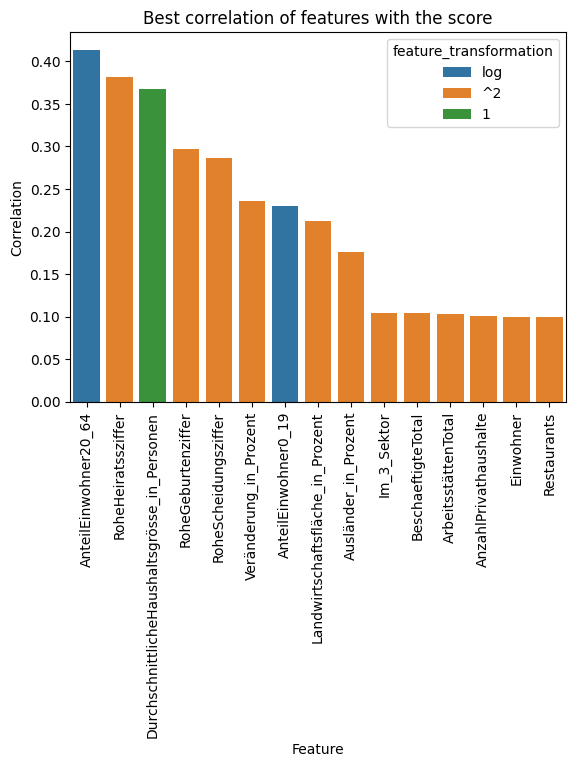

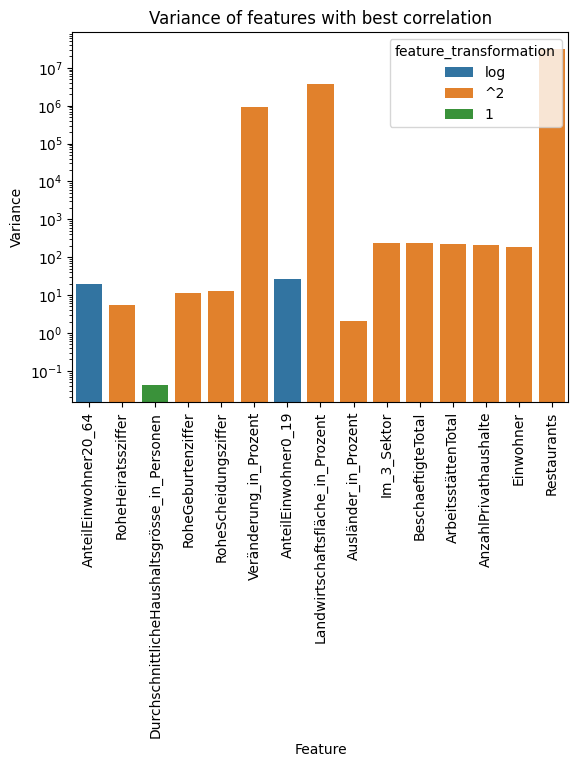

In [151]:
features = calculate_correlation(df_enriched_processed)

display(features)

plt.title('Best correlation of features with the score')
sns.barplot(data=features[0:15], x='feature_name', y='correlation', hue='feature_transformation')
plt.xticks(rotation=90)
plt.ylabel('Correlation')
plt.xlabel('Feature')
plt.show()

plt.title('Variance of features with best correlation')
sns.barplot(data=features[0:15], x='feature_name', y='variance', hue='feature_transformation')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('Variance')
plt.xlabel('Feature')
plt.show()

Calculate linear and boosting score for different combinations of the features which reached the highest correlation to the target variable.

In [154]:
def all_feature_combinations(elements):
    n = len(elements)
    all_combos = []
    
    for i in range(1, 2**n):
        subset = []

        for bit in range(n):
            if i & (1 << bit):
                subset.append(elements[bit])
        
        all_combos.append(subset)


    return all_combos

features = calculate_correlation(df_enriched_processed)

# using normalized and non-normalized for features linear regression
best_linear =  -np.inf
best_linear_features = []
combinations_normalized = features[['feature']][0:10].values.flatten()
combinations = all_feature_combinations(combinations_normalized)
i = 0
for feature in combinations:
    print(f'[{i} / {len(combinations)}]  Checking {feature} | best linear: {best_linear}')
    i += 1
    X, y = dataframeToXy(df_enriched_processed, 'Score', feature)
    linear = scoreLinear(X, y)
    if linear > best_linear:
        best_linear = linear
        best_linear_features = feature

# using non-normalized features for boosting
best_boost = -np.inf
best_boost_features = []
combinations_nonnormalized = features[features['feature_normalized'] == False][['feature']][0:10].values.flatten()
combinations = all_feature_combinations(combinations_nonnormalized)
i = 0
for feature in combinations:
    print(f'[{i} / {len(combinations)}]  Checking {feature} | best boost: {best_boost}')
    i += 1
    X, y = dataframeToXy(df_enriched_processed, 'Score', feature)
    boost = scoreBoosting(X, y)
    if boost > best_boost:
        best_boost = boost
        best_boost_features = feature

[0 / 1023]  Checking ['AnteilEinwohner20_64|normalized|log'] | best linear: -inf
[1 / 1023]  Checking ['RoheHeiratssziffer|normalized|^2'] | best linear: -184.66566370513803
[2 / 1023]  Checking ['AnteilEinwohner20_64|normalized|log', 'RoheHeiratssziffer|normalized|^2'] | best linear: -184.66566370513803
[3 / 1023]  Checking ['DurchschnittlicheHaushaltsgrösse_in_Personen'] | best linear: -161.72817113153505
[4 / 1023]  Checking ['AnteilEinwohner20_64|normalized|log', 'DurchschnittlicheHaushaltsgrösse_in_Personen'] | best linear: -161.72817113153505
[5 / 1023]  Checking ['RoheHeiratssziffer|normalized|^2', 'DurchschnittlicheHaushaltsgrösse_in_Personen'] | best linear: -154.01036767244315
[6 / 1023]  Checking ['AnteilEinwohner20_64|normalized|log', 'RoheHeiratssziffer|normalized|^2', 'DurchschnittlicheHaushaltsgrösse_in_Personen'] | best linear: -154.01036767244315
[7 / 1023]  Checking ['RoheGeburtenziffer|normalized|^2'] | best linear: -137.46566053985637
[8 / 1023]  Checking ['AnteilEi

# Final Result

In [155]:
linear, _ = runScoring(df_enriched_processed, 'Score', best_linear_features)
print(f'features : {best_linear_features}')
print(f'linear   : {linear}')

_, boost = runScoring(df_enriched_processed, 'Score', best_boost_features)
print(f'features : {best_boost_features}')
print(f'boosting : {boost}')

features : ['AnteilEinwohner20_64|normalized|log', 'RoheHeiratssziffer|normalized|^2', 'DurchschnittlicheHaushaltsgrösse_in_Personen', 'RoheGeburtenziffer|normalized|^2', 'Veränderung_in_Prozent|^2', 'AnteilEinwohner0_19|normalized|log', 'Ausländer_in_Prozent|normalized|^2']
linear   : -109.92801000756413
features : ['Einwohner0_19|^2', 'Einwohner65_plus|^2', 'ranking1_criteria1', 'ranking3_criteria3|^2']
boosting : -155.6912801028321
